In [ ]:
import cobra
# import thermo_flux
# from thermo_flux.io import load_excel as ex
from thermo_flux.core.model import ThermoModel
from equilibrator_api import  Q_
import pandas as pd
# from thermo_flux.io import helper_load as hl
import numpy as np


In [ ]:
INPUT_FOLDER='datafiles/'

## Import model

Here we load the default textbook model of E. coli from the COBRA package. 

Models can be imported directly from SBML format of COBRA models, using the function `cobra.io.read_sbml_model`. All format used by COBRA can be used (JSON,YAML,...).

In [ ]:
# Load a Cobra model
model = cobra.io.load_model('iAF1260')

# create the thermo model object from the cobra model 
tmodel = ThermoModel(model)
# Thermo-flux will automatically expand the biomass reaction to make the biomass output extracellualr and add charge transport if it is not already present
# this can be turned off by setting the expand_biomass and add_charge_transport flags to False
tmodel = ThermoModel(model, split_biomass=False, add_charge_exchange=False)



Output()

## Step 1: Definition of physical and biochemical parameters 


In [ ]:
# we use the pint package to define units for parameters using the Q_(value, unit) function
# it is important to use the same unit constructor as the equilibrator_api (from equilibrator_api import  Q_)
 
tmodel.pH = {"c": Q_(7.6), "e": Q_(7)} #pH
tmodel.I = {"c": Q_(0.25,'M'), "e": Q_(0.25,'M')} #ionic stength
tmodel.phi = {'ce':Q_(0.15,'V')} #membrane potential ‘ce’ represents the voltage between compartment ‘c’ and compartment 'e’ defined as Phic - Phie
tmodel.pMg = {'e': Q_(3), 'c': Q_(3)}

## Step 2: Definition of metabolites and chemical species

Metabolites must have annotations or InChI strings to be indetified in the eQuilibrator database

In [54]:
met = tmodel.metabolites.pi_c
print(met.annotation)

# Metabolites are assigned a compound from the equilibrator database that can be interacted with using the eQuilibrator api if desired
met.compound


{'sbo': 'SBO:0000247', 'bigg.metabolite': 'pi', 'biocyc': ['META:Pi', 'META:CPD-16459', 'META:PHOSPHATE-GROUP'], 'chebi': ['CHEBI:26078', 'CHEBI:18367', 'CHEBI:29139', 'CHEBI:39739', 'CHEBI:43470', 'CHEBI:35780', 'CHEBI:43474', 'CHEBI:26020', 'CHEBI:45024', 'CHEBI:39745', 'CHEBI:29137', 'CHEBI:14791', 'CHEBI:7793'], 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/db5219ee-60cb-4370-b066-340c9faf069c', '5882df9c-dae1-4d80-a40e-db4724271456/compound/84684967-eade-48d4-b25d-c4aede0a0836', '5882df9c-dae1-4d80-a40e-db4724271456/compound/ad82c39b-2edb-4953-b971-79a2d2ea6e26', '650babc9-9d68-4b73-9332-11972ca26f7b/compound/aac01fea-4223-49c1-8b12-cd50f11ebfc8', '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/c581b2ce-6238-45de-abc0-60ca8d47ed04'], 'hmdb': ['HMDB02105', 'HMDB00973', 'HMDB01429', 'HMDB02142', 'HMDB05947'], 'inchi_key': 'NBIIXXVUZAFLBC-UHFFFAOYSA-L', 'kegg.compound': 'C00009', 'kegg.drug': 'D05467', 'metanetx.chemical': 'MNXM9', 'reactome.compound': ['5228339', '11355

Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L)

In [55]:
charge, protons, Mg, species = met.average_charge_protons(round_dp=2, accuracy = 0.1)

#Metabolite species below a certain theshold can be ignored by changing the accuracy. i.e accuracy = 0.1 only considers micorspecies >10% of population shown in the abundance_norm column

print('{} containts {} protons, {} Mg and has a charge of {}'.format(met.id, protons, Mg, charge))

display(species)

pi_c containts 1.0 protons, 0.16 Mg and has a charge of -1.68


,charge,number_protons,number_magnesiums,ddg_over_rt,ddg_prime_over_rt,abundance,abundance_norm,abundance_round
0,-3,0,0,29.703348,26.246759,4.765247e-05,0.000000,0.00
1,-2,1,0,0.000000,16.510754,8.060807e-01,0.837301,0.84
2,-1,2,0,-16.002966,19.589902,3.707844e-02,0.000000,0.00
3,0,3,0,-20.147620,33.672517,2.838701e-08,0.000000,0.00
4,-1,0,1,-164.777429,26.492750,3.726086e-05,0.000000,0.00
5,0,1,1,-191.724505,18.149034,1.566328e-01,0.162699,0.16
6,1,2,1,-202.249082,25.297691,1.231007e-04,0.000000,0.00


The species distribution at different pH at a fixed ionic strength and pMg can also be viewed

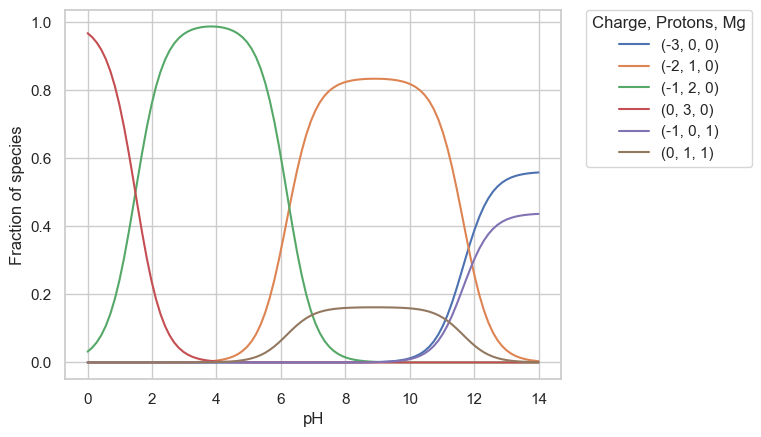

In [56]:
ax = thermo_flux.tools.drg_tools.pka_graph(met,accuracy=0, round_dp=False).plot()
ax.set_ylabel('Fraction of species')
ax.set_xlabel('pH')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Charge, Protons, Mg')

# Steps 2-6



Calculation of all thermodyanmic parameters in a model is combined into a single function "tmodel.update_thermo_info:. 

This function identifies all compounds based on their annotations (Step 2), calculates metabolites formation energies (Step 3), and calculates the Gibbs free energy of reactions (Step 6).

In [57]:
tmodel.update_thermo_info(fit_unknown_dfG0=True, round_dp=2)

Identifying compounds...
[████████████████████████████████████████] 76/76 charge_c                  

Estimating dfG0'...
biomass_c 0 kilojoule / mole
biomass_e 0 kilojoule / mole
[████████████████████████████████████████] 78/78 Mg_c                      

Estimating drG0'...


 Total transported H: 2.0, total transported charge: -1.0, Transported free H+: {'c': 1.0, 'e': -1.0}


[████████████████████████████████████████] 99/99 EX_charge                                                



## Step 3: Calculation of formation energies of metabolites

The formation energies of metabolites are calculated using the eQuilibrator database. After update_thermo_info has been run metabolite formation energies can be examined. 

In [58]:
print(met.id, 'formation energy:', met.dfG0, '\n transformed formation energy:', met.dfG0, '\n formation energy uncertainty:', met.dfG_SE)

pi_c formation energy: -1095.2054811974629 kilojoule / mole 
 transformed formation energy: -1095.2054811974629 kilojoule / mole 
 formation energy uncertainty: 0.7487227046582053 kilojoule / mole


## Step 4: Delineation of transporter characteristics 

Transporter characteristics are automatically calculated wherever possible. The most abundant species in the inner compartment is assumed to be the species that is transported. 

For calculation of the drG of transport, the total protons and charge transported are calcualted. 


In [59]:
rxn = tmodel.reactions.PIt2r
print(rxn)

n_h_inner, z_inner,n_h_outer, z_outer,inner_comp, outer_comp, balanced = rxn.transported_c_h(round_dp=2)

#the free protons transported can also be calculated and may be different from the total hydrogens transported
transported_free_h = tmodel.reactions.PIt2r.transported_h

print('The reaction {} transports a total of {} hydrogens and {} charge from the {} to the {}'.format(rxn.id, n_h_inner,z_inner, inner_comp, outer_comp))

#the drg transport components for charge and protons are calculated separately

drG_charge = rxn.drG_c_transport
drG_protons = rxn.drG_h_transport
drGtransport = rxn.drGtransport

print('The Gibbs energy components of {} are {} for the charge and {} for the protons'.format(rxn.id, drG_charge, drG_protons))

print('The total Gibbs energy of transport for {} is {}'.format(rxn.id, drGtransport))

#note that the reaction was automatically balanced to facilitate accurate calculation. 0.85 protons appear on the extracellular side becuase 15% of the extracellular Pi is in the form of H2PO4-

PIt2r: 0.85 h_e + pi_e <=> h_c + pi_c
The reaction PIt2r transports a total of 2.0 hydrogens and -1.0 charge from the c to the e
The Gibbs energy components of PIt2r are 14.47275 kilocoulomb * volt / mole for the charge and -6.960741906625094 kilojoule / mole for the protons
The total Gibbs energy of transport for PIt2r is 7.512008093374906 kilojoule / mole


update_thermo_info gave a warning about FRUpts2 and GLCpts2. as the transported metabolite could not be automatically calcualted. 

This is beacause they represent PTS transporters in which a metabolic reaction occurs simultaneously with transport. Here we must explicitely define the transported metabolite, in the direction the reaction is written. 

In [60]:
print(tmodel.reactions.FRUpts2)
tmodel.reactions.FRUpts2.transported_mets = {tmodel.metabolites.fru_e:-1}

print(tmodel.reactions.GLCpts)
tmodel.reactions.GLCpts.transported_mets = {tmodel.metabolites.glc__D_e :-1}

FRUpts2: fru_e + pep_c --> f6p_c + pyr_c
GLCpts: glc__D_e + pep_c --> g6p_c + pyr_c


Often it is not known which species of a metabolites is being transported with which stoichiometry. By default, Thermo-Flux assumes the major species in the inner compartment is transported. To add more possible transporter variants a separate transport reaction should be defined for each possible charge state of the transported metabolites. Transported metabolite species with an abundance >10% in the inner compartment are considered as potentially transported species. Additionally, in case of transport processes, for which at the given pH value no charge neutral transport variant exists, we suggest introducing an additional transport reaction, in which protons balancing the charge are co-translocated together with the respective species, i.e. adding a proton symporter or antiporter. This additional transport variant ensures that for every metabolite, a transport variant exists that does not translocate net charge. Addition of transporter variants can automatically be achieved with the function reaction.add_transporter_variants()

In [61]:
trans_rxns = []
for rxn in tmodel.reactions:
    if len(rxn.compartments) > 1:
        trans_rxns.append(rxn)

In [62]:
for rxn in trans_rxns:
    new_reactions = thermo_flux.tools.drg_tools.add_transporter_varaints(rxn,balance_charge=True,add_charge_neutral = True, round_dp=2)
    if new_reactions is not None:
        if len(new_reactions) > 0:
            print(rxn)
            for new_reaction in new_reactions:
                print(new_reaction)

AKGt2r: akg_e + charge_c + h_e <=> akg_c + charge_e + h_c
AKGt2r0: akg_e + 2.0 h_e <=> akg_c + 2.0 h_c
PIt2r: charge_c + 0.85 h_e + pi_e <=> charge_e + h_c + pi_c
PIt2r0: 1.85 h_e + pi_e <=> 2.0 h_c + pi_c
SUCCt3: 3.0 charge_e + h_e + succ_c --> 3.0 charge_c + h_c + succ_e
SUCCt3+1: charge_e + h_c + succ_c --> charge_c + h_e + succ_e
SUCCt3+2: 2.0 h_c + succ_c --> 2.0 h_e + succ_e
SUCCt30: 2.0 charge_e + succ_c --> 2.0 charge_c + succ_e
ETOHt2r: charge_e + etoh_e + h_e <=> charge_c + etoh_c + h_c
ETOHt2r0: etoh_e <=> etoh_c
transporter variant FORt0 already in model as FORt2: for_e + h_e --> for_c + h_c
FORt: charge_c + for_e <-- charge_e + for_c
FORt2: for_e + h_e --> for_c + h_c
NH4t: charge_e + nh4_e <=> charge_c + nh4_c
NH4t0: h_c + nh4_e <=> h_e + nh4_c


## Step 5. Execution of pH-dependent charge and proton balancing 

Reactions can now be automatically proton and charge balanced

In [63]:
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False, round_dp=2) #for simplicity we're ignoring Mg balance here but it could be enabled 


## Step 6. Calculation of Gibbs energy of reactions 

To ensure all Gibbs energy of reactions are calcualted after we have added and modified some transporters, re-run the function update_thermo_info.

In [64]:
tmodel.update_thermo_info(fit_unknown_dfG0=True)

Identifying compounds...
[████████████████████████████████████████] 78/78 Mg_c                      

Estimating dfG0'...
[████████████████████████████████████████] 78/78 Mg_c                                                                                                                          

Estimating drG0'...
[████████████████████████████████████████] 106/106 NH4t0                                                    



 Total transported H: 2.0, total transported charge: -1.0, Transported free H+: {'c': 1.0, 'e': -1.0}
 Total transported H: 3.0, total transported charge: 0.0, Transported free H+: {'c': 2.0, 'e': -2.0}


In [65]:
for rxn in tmodel.reactions:
    print(rxn.id, round(rxn.drG0prime.m,3),'±', round(rxn.drG_SE, 3))

PFK -19.765 ± 0.675 kilojoule / mole
PFL -19.769 ± 1.489 kilojoule / mole
PGI 2.63 ± 0.383 kilojoule / mole
PGK 19.524 ± 0.441 kilojoule / mole
PGL -26.794 ± 1.659 kilojoule / mole
ACALD -22.046 ± 1.2 kilojoule / mole
AKGt2r 13.922 ± 0.0 kilojoule / mole
PGM -4.485 ± 0.361 kilojoule / mole
PIt2r 3.745 ± 0.0 kilojoule / mole
ALCD2x 16.647 ± 0.323 kilojoule / mole
ACALDt 13.921 ± 0.0 kilojoule / mole
ACKr 13.918 ± 0.55 kilojoule / mole
PPC -41.529 ± 3.112 kilojoule / mole
ACONTa 8.354 ± 1.134 kilojoule / mole
ACONTb -1.642 ± 1.135 kilojoule / mole
ATPM -30.988 ± 0.304 kilojoule / mole
PPCK 10.541 ± 3.12 kilojoule / mole
ACt2r 10.444 ± 0.0 kilojoule / mole
PPS -7.787 ± 0.498 kilojoule / mole
ADK1 0.358 ± 0.16 kilojoule / mole
AKGDH -28.183 ± 3.885 kilojoule / mole
ATPS4r 30.988 ± 0.304 kilojoule / mole
PTAr 8.561 ± 0.606 kilojoule / mole
PYK -23.559 ± 0.424 kilojoule / mole
BIOMASS_Ecoli_core_w_GAM 3629.081 ± 19.273 kilojoule / mole
PYRt2 10.441 ± 0.0 kilojoule / mole
CO2t 0.0 ± 0.0 kiloj

## Step 7. Establishment of the thermodynamic-stoichiometric solution space 
Now the model is fully parameterized we can run FBA style optimizations with thermodynamic constraints. 

The model can still be optimized using standard COBRA functions and FBA. We can test there are no issues with the stoichiometry by running an standard FBA optimization. 

In [66]:
tmodel.objective = tmodel.reactions.biomass_EX #make sure the objective is the biomass export reaction 
sol = tmodel.optimize()
tmodel.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.9577,1,1.57%
glc__D_e,EX_glc__D_e,10,6,98.43%
nh4_e,EX_nh4_e,7.175,0,0.00%
pi_e,EX_pi_e,4.841,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
for_e,EX_for_e,-4.958,1,100.00%
h2o_e,EX_h2o_e,-8.628,0,0.00%
h_e,EX_h_e,-132.1,0,0.00%
biomass_e,biomass_EX,-1.316,0,0.00%


Metabolite concnetration bounds can be defined

In [67]:
tmodel.metabolites.atp_c.lower_bound = Q_(10, 'mM')
tmodel.metabolites.atp_c.upper_bound = Q_(10, 'mM')

tmodel.metabolites.glu__L_c.upper_bound = Q_(100, 'mM')

#metabolites could also be defined as ratios as long as they always appear in pairs and no biosynthesis reactions are present e.g. NAD and NADH

tmodel.metabolites.nad_c.upper_bound = Q_(20, 'M')
tmodel.metabolites.nad_c.lower_bound = Q_(10, 'M')

tmodel.metabolites.nadh_c.upper_bound = Q_(1, 'M')
tmodel.metabolites.nadh_c.lower_bound = Q_(1, 'M')

In [68]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = 12, error_type = 'covariance')

# this has now created a Gurobi model object accessible via tmodel.m
print(tmodel.m)

# The gurobi model object can be interacted with directly via the gurobypy api. Extensive documentation can be found here: https://www.gurobi.com/documentation/10/refman/py_model.html

#set a 15s time limit for the solver
tmodel.m.Params.TimeLimit = 15

# start the optimization 
tmodel.m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
<gurobi.Model MIP instance minlp: 967 constrs, 899 vars, Parameter changes: TimeLimit=10.0, Username=(user-defined), NonConvex=2>
Set parameter TimeLimit to value 15
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 967 rows, 899 columns and 6043 nonzeros
Model fingerprint: 0x355d2252
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 793 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+08]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+08]
  RHS range        [1e-14, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 511 ro

### Optimization results 

View the optimisation results and check the gibbs energy balance was met correctly.



In [69]:
# All the TFBA variables are now stored in the tmodel.mvars dictionary
print(tmodel.mvars.keys())
# these are gurobi mvar objects and can be modified (e.g. lower and upper bounds start values etc.) using the.gurobipy api

# otherwise a solution dataframe is generated by tmodel.solution()
sol = tmodel.solution()

#create a list of internal and exchange reactions based on cobra boundary function 
int_rxns = [rxn.id for rxn  in tmodel.reactions if rxn not in tmodel.boundary]
ex_rxns = [rxn.id for rxn  in tmodel.reactions if rxn  in tmodel.boundary]

#index the solution dataframe using these lists and sum the gibbs energy dissipation 
print('Gdiss internal: ', sol.loc[int_rxns]['Gdiss'].sum())
print('Gdiss exchange: ', sol.loc[ex_rxns]['Gdiss'].sum())

display(sol)


dict_keys(['b', 'v', 'drGp', 'drGn', 'ln_conc', 'drG', 'drG_error', 'drG_conc', 'qm', 'mnorm', 'Gdiss', 'g_2'])
Gdiss internal:  -3637.8027868286476
Gdiss exchange:  3637.7988060592797


,v,drG,Gdiss,drG0_prime,drG_error,drG_conc,b,condition
reaction,,,,,,,,
PFK,7.756303,-3.249287,-25.202457,-1.976517e+01,0.139553,16.376329,1.000000,0
PFL,4.482633,-10.708597,-48.002706,-1.976903e+01,1.612960,7.447471,1.000000,0
PGI,5.182294,-5.992338,-31.054058,2.630066e+00,0.053835,-8.676239,1.000000,0
PGK,-16.650323,2.361805,-39.324813,1.952409e+01,-0.068088,-17.094193,0.000000,0
PGL,4.506289,-19.314062,-87.034744,-2.679429e+01,-0.246750,7.726973,1.000000,0
ACALD,-0.000003,9.967918,-0.000028,-2.204629e+01,0.350522,31.663684,0.000000,0
AKGt2r,0.000000,28.916418,0.000000,1.099270e+01,0.000000,17.923721,0.000000,0
PGM,-15.835386,2.062669,-32.663156,-4.485410e+00,-0.044400,6.592478,0.000000,0
PIt2r,2.003948,-0.500676,-1.003329,1.125718e+01,0.000000,-11.757856,1.000000,0


The method ThermoModel.solution() returns the dataframe of the main Gurobi variables and their values

In [70]:
tmodel.solution().loc[tmodel.solution().index.str.contains('ATP')]


,v,drG,Gdiss,drG0_prime,drG_error,drG_conc,b,condition
reaction,,,,,,,,
ATPM,8.390000,-59.644260,-500.415339,-30.988323,0.081714,-28.737652,1.0,0
ATPS4r,18.339069,-12.168224,-223.153899,-40.824161,-0.081714,28.737652,1.0,0


### Scanning a variable bound 

We're often interested in the effect of the gibbs energy dissipation limit as we increase the glucose uptake rate. We can take advantage of the Gurobi multi scenario feature to scan through a range of values for a particular variable and solve the optimisations in an efficeint way. 

In [71]:
# First we fix the drG_errors to the values from our initial optimization 
# This is optional but will:
# i: help the solver converge faster
# ii: ensure we have a consistent set of drG0prime values for each glucose uptake condition (this is analgous to running the regressions on literature data and using this to fix the drGerror values)) 

# the qm vector defines the errors in the covariance matrix 
qm = tmodel.mvars['qm'].x #get the qm values from the initial solution
#fix the values in the model 
tmodel.mvars['qm'].lb = qm 
tmodel.mvars['qm'].ub = qm
tmodel.m.update() #update the model with the new bounds

#define a range of glucose uptake rate values to scan through 
GUR_range =  np.linspace(-1,-15, 15) 
print(GUR_range)

#set up a multiscenario optimization to scan over the glucose upake rate
thermo_flux.solver.gurobi.variable_scan(tmodel, GUR_range, var = tmodel.mvars['v'][0][tmodel.reactions.index(tmodel.reactions.EX_glc__D_e)]) # here we get the index for the glucose uptake reaction and use this to index the v variable in the gurobi model

tmodel.m.optimize()

[ -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13. -14.
 -15.]
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 967 rows, 899 columns and 6043 nonzeros
Model fingerprint: 0xb4ad0afc
Model has 22 quadratic constraints
Model has 1 general constraint
Variable types: 793 continuous, 106 integer (106 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+08]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-06, 1e+08]
  RHS range        [1e-14, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Solving a multi-scenario model with 15 scenarios...


MIP start from previous solve produced solution with objective 0.635553 (0.01s)
MIP start from previous solve produced solution

In [72]:
#get the fluxes from the multiscenario optimization
fluxes = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'v') 
fluxes= pd.DataFrame(fluxes[0].T, index = [rxn.id for rxn in tmodel.reactions])
display(fluxes)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PFK,0.955992,1.837040,2.609250,3.381461,4.153671,4.843673,5.519407,6.195142,6.957509,7.882748,8.807987,9.733226,1.066154e+01,1.159863e+01,1.253572e+01
PFL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.486987,5.769590,10.052192,14.334795,1.796948e+01,1.975344e+01,2.153740e+01
PGI,0.990930,1.869682,2.420071,2.970461,3.520851,3.713025,3.843033,3.973041,4.345975,5.175624,6.005273,6.834922,7.671574e+00,8.528227e+00,9.384880e+00
PGK,-1.882390,-3.622402,-5.254681,-6.886960,-8.519240,-10.136110,-11.750306,-13.364501,-15.075487,-16.968441,-18.861395,-20.754349,-2.265170e+01,-2.456163e+01,-2.647155e+01
PGL,0.000000,0.103869,0.536236,0.968603,1.400970,2.199784,3.062193,3.924602,4.545336,4.711709,4.878081,5.044454,5.203988e+00,5.343987e+00,5.483986e+00
ACALD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-3.316222e-01,-1.610492e+00,-2.889362e+00
AKGt2r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
PGM,-1.816204,-3.429387,-4.935833,-6.442279,-7.948725,-9.499831,-11.058687,-12.617544,-14.282324,-16.146246,-18.010168,-19.874091,-2.174361e+01,-2.362910e+01,-2.551459e+01
PIt2r,0.162755,0.474628,0.784055,1.093483,1.402910,1.564626,1.700706,1.836787,1.950406,2.021797,2.093187,2.164578,2.233034e+00,2.293107e+00,2.353181e+00
ALCD2x,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.316222e-01,-1.610492e+00,-2.889362e+00


### Plot the fluxes

Create a function to handle plotting of mutiple exchange fluxes and overlaying individual data points. 

In [73]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import ceil


def exchange_plot(flux_list, rxn_list = ['biomass_EX', 'EX_co2_e', 'EX_acald_e','EX_ac_e','EX_for_e','EX_etoh_e','EX_pyr_e','EX_o2_e'],
                  x_axis_data= 'EX_glc__D_e',
                  titles = ['Biomass production', 'CO2 production', 'Acetaldehyde production', 'Acetate production', 'Formate production', 'EtOH production','Pyruvate production','Oxygen Uptake'],
                  y_upper = [1.5, 30,20.4,14.4,17.7,14.2,14.4, 15],
                  overlay=True,
                  legend_labels = ['WT'],
                  flux_data = None,
                  save = False):
    
    cols = 4
    rows = ceil(len(rxn_list)/cols)
 
    #overlay all plot on one graph
    if overlay:
        #make a subplot figure
        fig, axes = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True,figsize=(10,8),dpi= 300)

    titles = ['Biomass production', 'CO2 production', 'Acetaldehyde production', 'Acetate production', 'Formate production', 'EtOH production','Pyruvate production','Oxygen Uptake']


    for ii, fluxes in enumerate(flux_list):

        if not overlay: #make a new subplot for each set of fluxes 
            fig, axes = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True,figsize=(10,8),dpi= 300)

        #loop through the figure axis and add data to each plot
        for i, ax in enumerate(fig.axes):
                
            data = abs(fluxes.loc[rxn_list[i]]).sort_index()
            data.index = abs(fluxes.loc[x_axis_data])
            if 0 in data:
                data = data.drop(0)


            #if the fluxes are <1 then multiply by -1
            if data.max() < 0:
                data = data*-1

            data.plot(style='o-',linewidth=3,markersize=3,xlabel = 'GUR (mmol gCDW$^{-1}$ h$^{-1}$ )', ylabel = 'Flux',  title = titles[i] , ax=ax,xlim=[0,15],ylim =0, alpha = 0.8) 

            if flux_data is not None:
                #add the experimental data to the plot
                if rxn_list[i] in flux_data.columns.to_list():
                    exp_data = flux_data[['EX_glc__D_e', rxn_list[i]]]
                    if legend_labels[ii] in exp_data.index.to_list():
                        exp_data =  exp_data.loc[legend_labels[ii]]

                        ax.scatter(marker = 'x',s = 50, color=ax.lines[-1].get_color() ,x=exp_data.loc['EX_glc__D_e'], y=exp_data.loc[rxn_list[i]])

        #add the legend - have to do this manually to get the lines and data to match... 
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        handles= []
        for i, ko in enumerate(legend_labels):
            handle = mlines.Line2D([], [], color=colors[i], marker='o',
                                    markersize=5, label=ko)

            handles.append(handle)

        for i, ax in enumerate(fig.axes):
        
            ax.legend(handles = handles)

#         if save:
# #             plt.savefig(legend_labels[ii]+'_.png')

        #hide the plot
        if not overlay:
            plt.close(fig)

    return fig

Import data from knock out experiments and overlay this on the simulated fluxes

### Comparing to published experimental data

Next we can compare to the published experimental data used in the Neibel et.al. 2019 paper to run regressions on the genome scale E. coli model. 

In [74]:
#import experimental data from Neibel et. al. 2019
reg_data = hl.excel_to_df(f'{INPUT_FOLDER}/data_allC.xlsx')


reg_data['dvmeas'] = reg_data['dvmeas'].reset_index()
reg_data['dvmeas'].columns = ['cond','rxn','mean_sd','Value']
reg_data['dvmeas'] = reg_data['dvmeas'].replace({'biomass':'biomass_EX'})
reg_data['dvmeas'] = reg_data['dvmeas'].pivot(index=['cond', 'rxn'], columns='mean_sd', values='Value').rename_axis(None, axis=1)
reg_data['dvmeas'] = reg_data['dvmeas'].fillna(0)

#rename reactions to match this textbook model example 
reg_data['dvmeas'] = reg_data['dvmeas'].rename({'EX_ac':'EX_ac_e',
                          'EX_co2':'EX_co2_e',
                          'EX_glc':'EX_glc__D_e',
                          'EX_o2':'EX_o2_e',
                          'EX_pyr':'EX_pyr_e'
                          }) 

#Dataframe of experimental fluxes 
reg_all = reg_data['dvmeas'].reset_index()

reg_all = reg_all.pivot(index='cond',columns='rxn', values='mean')




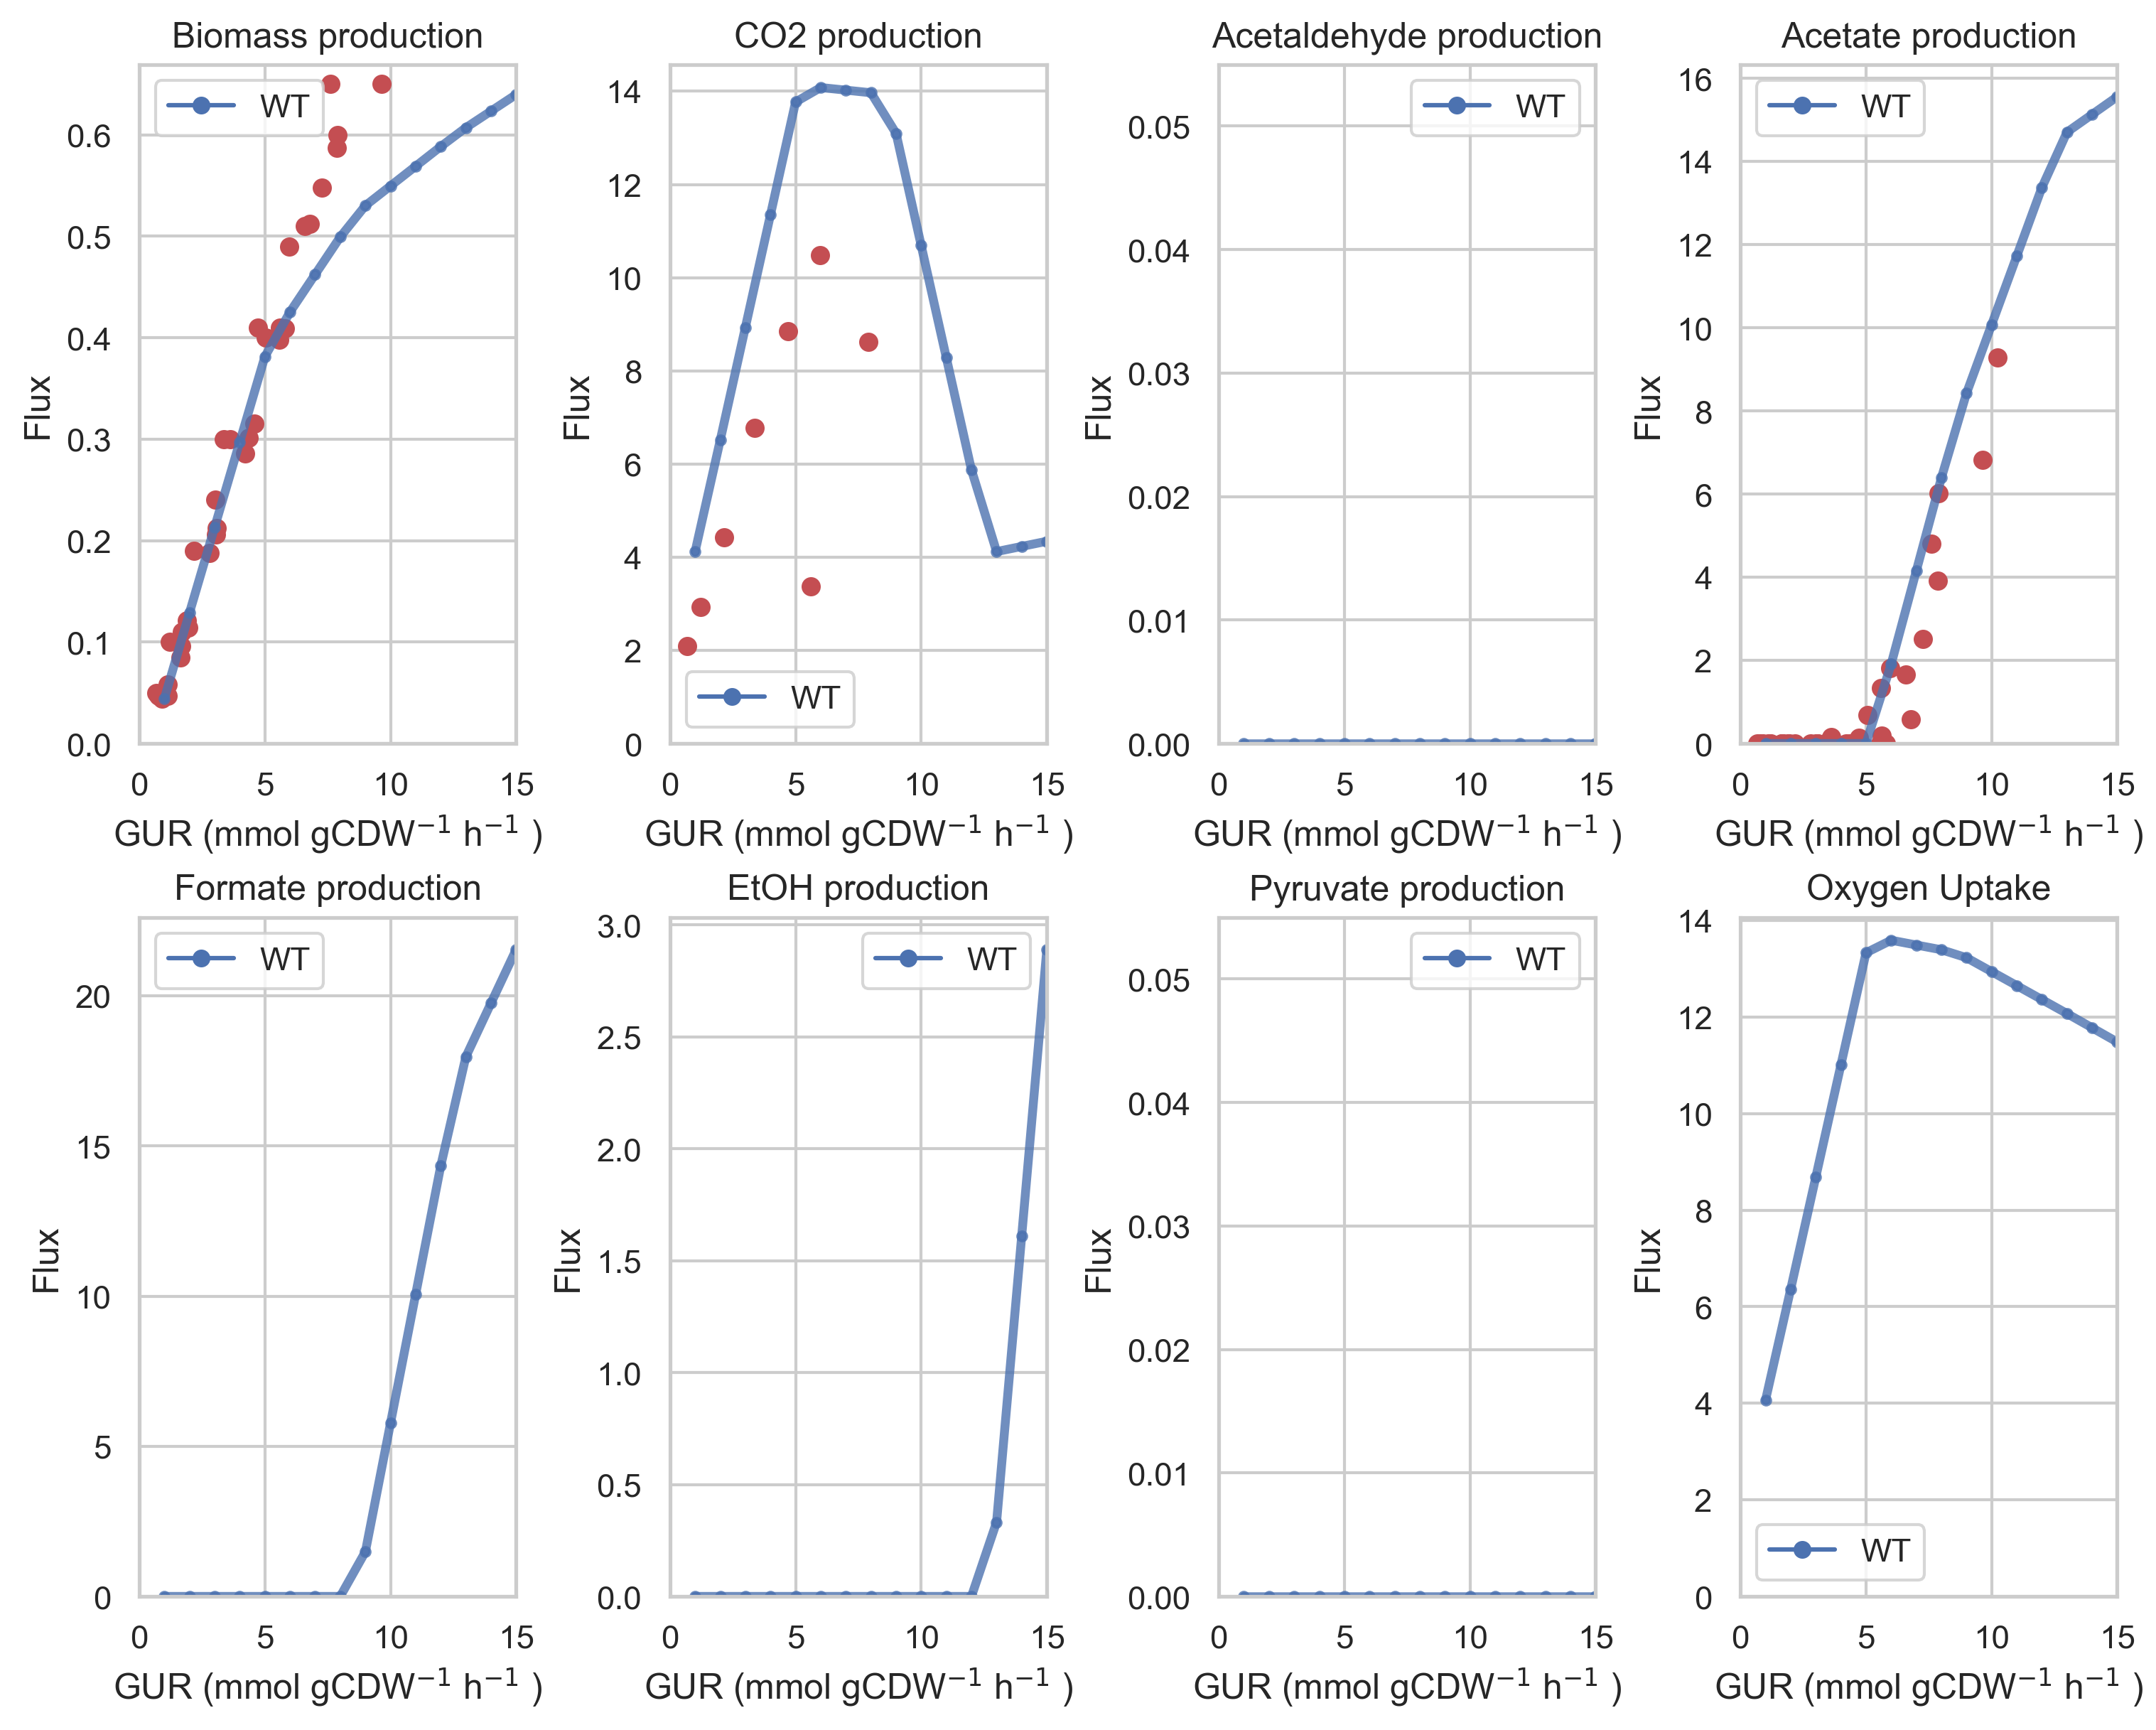

In [75]:
## make a new plot with all the data 

fig = exchange_plot([fluxes])

rxn_list = ['biomass_EX', 'EX_co2_e', 'EX_acald_e','EX_ac_e','EX_for_e','EX_etoh_e','EX_pyr_e','EX_lac__D_e']
for i, ax in enumerate(fig.axes):

    #add the experimental data to the plot
    if rxn_list[i] in reg_all.columns.to_list():
        exp_data = reg_all[['EX_glc__D_e', rxn_list[i]]]
        

        ax.scatter(marker = 'o',s = 30, color='r' ,x=abs(reg_all['EX_glc__D_e']), y=abs(reg_all[rxn_list[i]]))



Analyse the contribution of exchange reactions in the total gibbs energy dissipation rate

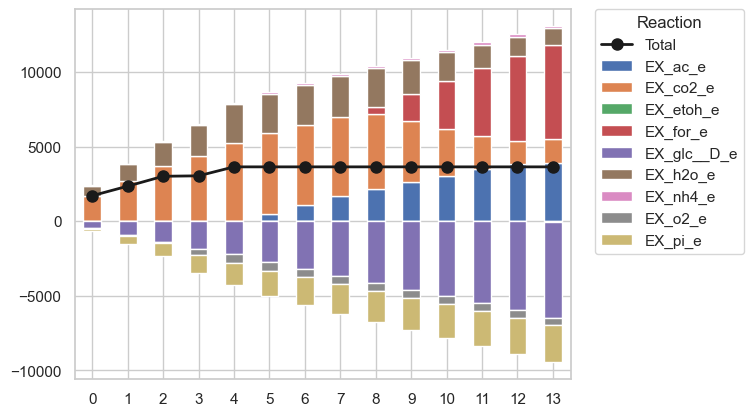

In [76]:
Gdiss = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'Gdiss') 
Gdiss= pd.DataFrame(Gdiss[0].T, index = [rxn.id for rxn in tmodel.boundary])

#drop column 14
Gdiss = Gdiss.drop(14, axis=1)

#round values to 5 dp
Gdiss = Gdiss.round(5)

#drop rows from gdiss with all zeros
Gdiss = Gdiss.loc[(Gdiss!=0).any(axis=1)]

#make a stacked bar graph for each condition in Gdiss (columns)
import matplotlib.pyplot as plt

# Create a stacked line graph
Gdiss.T.plot(kind='bar', stacked=True)

#overlay plot with sum of column
Gdiss.sum().plot(secondary_y=False, color='k', marker='o', linewidth=2, markersize=8, label='Total')


#put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Reaction')

#


## Step 8. Regression: fitting models to experimental data

So far we have just displayed the experimental data alongside the model predictions. Now lets try fitting the model to the experimental data.

In [77]:
#remove the ATP maintenance requirement
tmodel.reactions.ATPM.lower_bound = 0

#remove the bound on the glucose uptake flux (previously set to -10))
tmodel.reactions.EX_glc__D_e.lower_bound = -1000

In [78]:
#We built a thermo-model with multiple conditions - these are all in the model simultaneously, so the model can get quite large with many conditions! 

conds = ['Vemuri1','Vemuri2','Vemuri3','Vemuri4','Vemuri5','Vemuri6','Vemuri7'] # these match the indexes of the data in reg_data

flux_data = reg_data['dvmeas']

tmodel.m = None #clear any previously built optimization models 

#create the TFBA model 
tmodel.add_TFBA_variables(conds = conds, gdiss_constraint = False, error_type='covariance') # set the gdiss_constraint to False to prevent constrianing the model to a Gdiss lmimit

#add regression constraint to this TFBA model 
tmodel.regression(conds,
                  flux_data=flux_data, #provide the experimental data as a dataframe indexed by condition and reaction
                  metabolite_data=None, 
                  volume_data=None,
                  conc_fit=False,
                  error_type = 'covariance', 
                  flux_fit=True, #fit to the flux data 
                  drG_fit=True,  # optional, minimise the drG errors to make the drG0prime close to the mean values 
                  resnorm=2) #the norm to use for the regression 1: L1 norm (sum of absolute differences), 2: L2 norm (sum of squared differences)
                


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [79]:
tmodel.m.params.timeLimit = 120
tmodel.m.optimize()

Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M3 Max
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6126 rows, 5257 columns and 23366 nonzeros
Model fingerprint: 0xe1255662
Model has 54 quadratic objective terms
Model has 35 quadratic constraints
Model has 1 general constraint
Variable types: 4515 continuous, 742 integer (742 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+08]
  QMatrix range    [2e+03, 1e+06]
  QLMatrix range   [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e-05, 1e+08]
  RHS range        [1e-14, 1e+08]
  QRHS range       [3e+01, 2e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3199 rows and 2781 columns
Presolve time: 0.03s
Presolved: 2928 rows, 2530 columns, 11416 nonze

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# function for plotting the results of flux regression 
def reg_flux_plot(tmodel, flux_data, conds):
    mvars = tmodel.mvars

    mean_flux = flux_data.loc[conds].unstack(level=0)['mean']
    mean_flux = mean_flux.fillna(0)
    sd=flux_data.loc[conds].unstack(level=0)['sd']

    #get flux solution 
    flux_df = pd.DataFrame(mvars['v'].getAttr("x")).T
    flux_df['rxn_id'] = [rxn.id for rxn in tmodel.reactions]
    flux_df = flux_df.set_index('rxn_id')

    fitted_flux = flux_df.loc[mean_flux.index]
    fitted_flux.columns = conds

    sns.set(rc={"figure.dpi":100})
    sns.set_theme(style="whitegrid", palette=None)

    df = pd.concat([mean_flux, fitted_flux,sd], keys = ['mean', 'fitted','sd'], axis=0).unstack(level=1).T.reset_index()
    g= sns.lmplot( x="mean", y="fitted", data=df, col='rxn', legend=False, height=5, aspect=1, facet_kws={'sharex':False, 'sharey':False}, hue='level_0',col_wrap=4)

    # make sure all the axis are square 
    for ax in g.axes:
        ax.set_aspect('equal')
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xlim(min(xmin,ymin),max(xmax,ymax))
        ax.set_ylim(min(xmin,ymin),max(xmax,ymax))

        ax.legend()
    pd.set_option('display.max_rows', 5000)
    df['residual'] = abs((df['fitted'] - df['mean']))
    df['L2_residual'] = (df['fitted'] - df['mean'])**2

    df.index=df['level_0']+'_'+df['rxn']
    df = df.sort_values(by='residual', ascending=False)

    return df, g


Plot the results of the regression. Note how in this textbook model the biomass output is systematically underestimated. This might be due to differences in the biomass composition or maybe a missing carbon input source or more efficient metabolic pathway... 

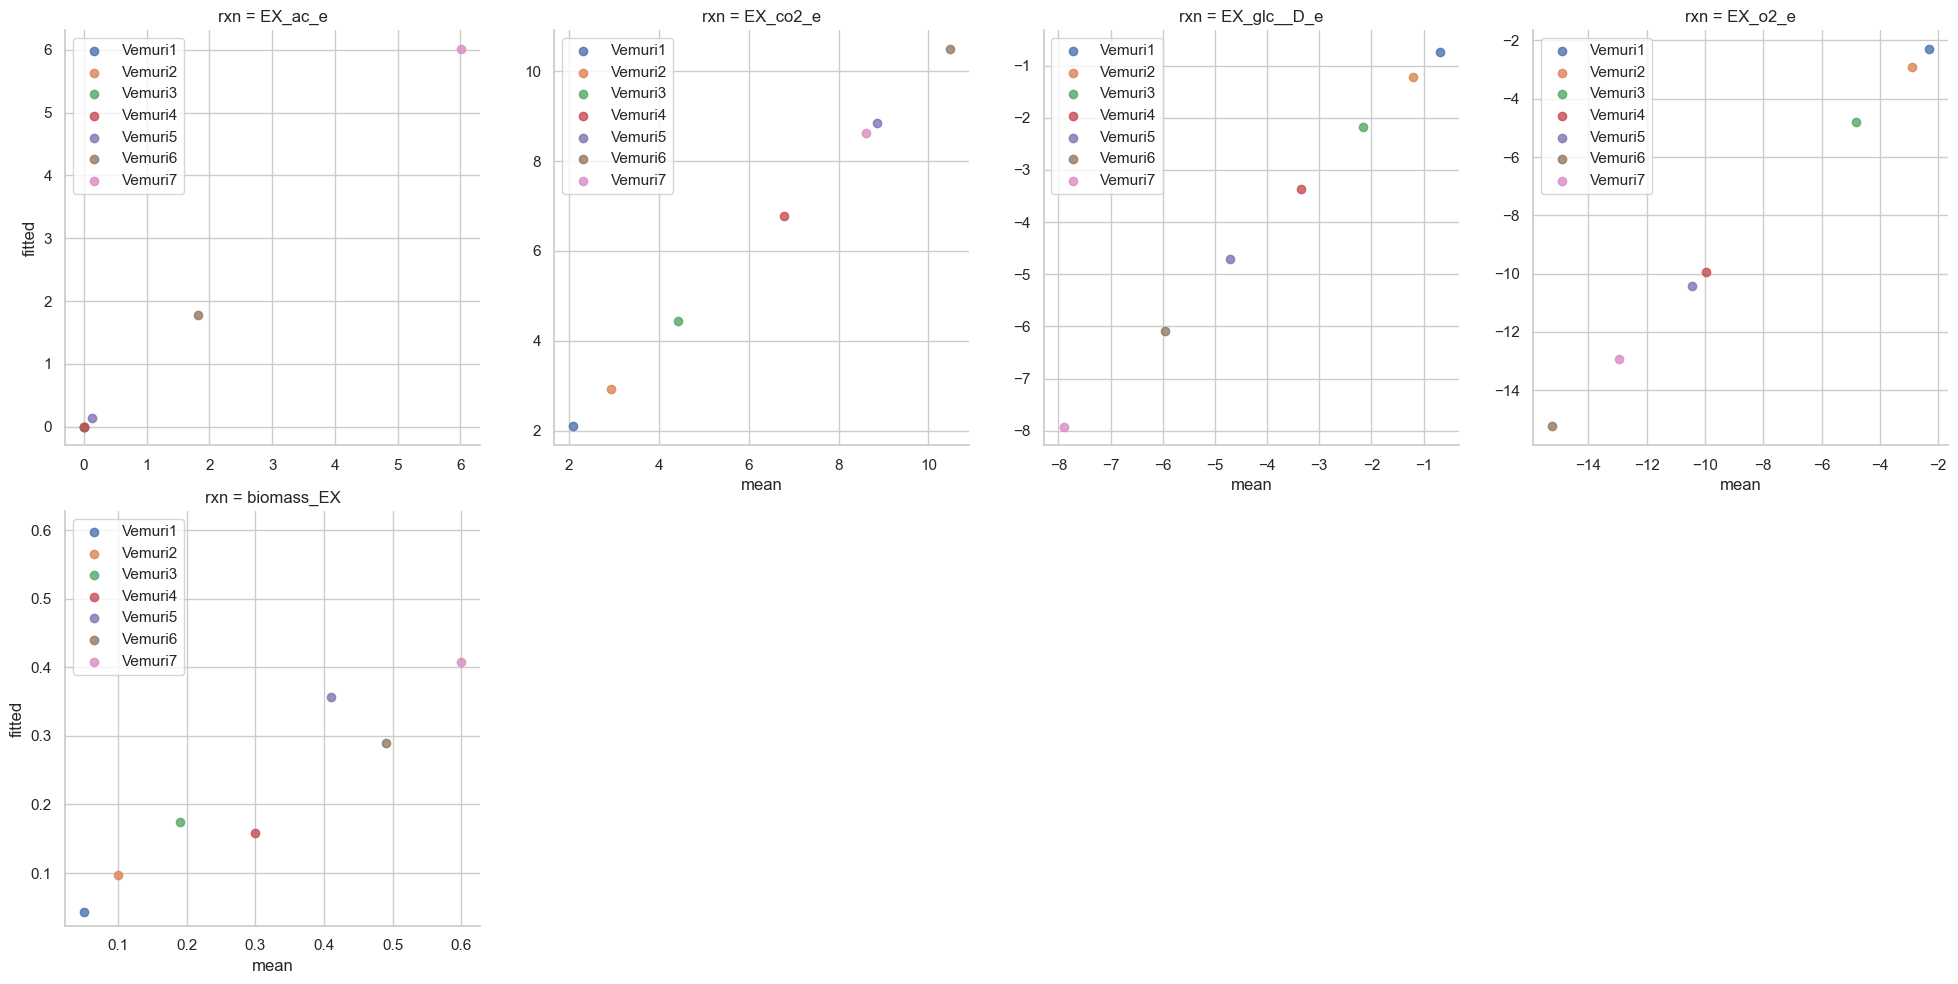

In [81]:
flux_reg, g = reg_flux_plot(tmodel, flux_data, conds)

<Axes: xlabel='growth_rate', ylabel='Gdiss'>

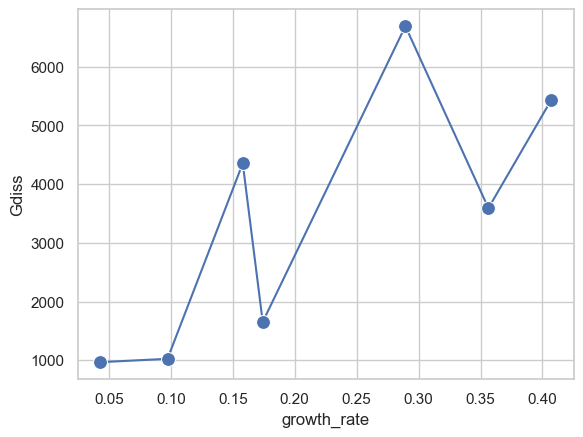

In [82]:
#calculate gdiss from exchange fluxes 
#for each condition sum Gdiss in sol 
sol = tmodel.solution()
sol = sol.loc[[rxn.id for rxn in tmodel.reactions if rxn in tmodel.boundary]]

#group gdiss by condition 
gdiss = sol.groupby('condition')['Gdiss'].sum()
gdiss =  pd.DataFrame(gdiss)

gdiss['growth_rate'] = sol.loc['biomass_EX'].set_index('condition')['v']
gdiss

# plot the gibbs energy dissipation 

#plot the gdiss against growth rate with joined dots
sns.lineplot(data=gdiss, x='growth_rate', y='Gdiss', marker='o', markersize=10)